In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [16]:
# Set paths for your dataset
train_dir = '/content/drive/MyDrive/Teeth DataSet/Teeth_Dataset/Training'
val_dir = '/content/drive/MyDrive/Teeth DataSet/Teeth_Dataset/Validation'
test_dir = '/content/drive/MyDrive/Teeth DataSet/Teeth_Dataset/Testing'

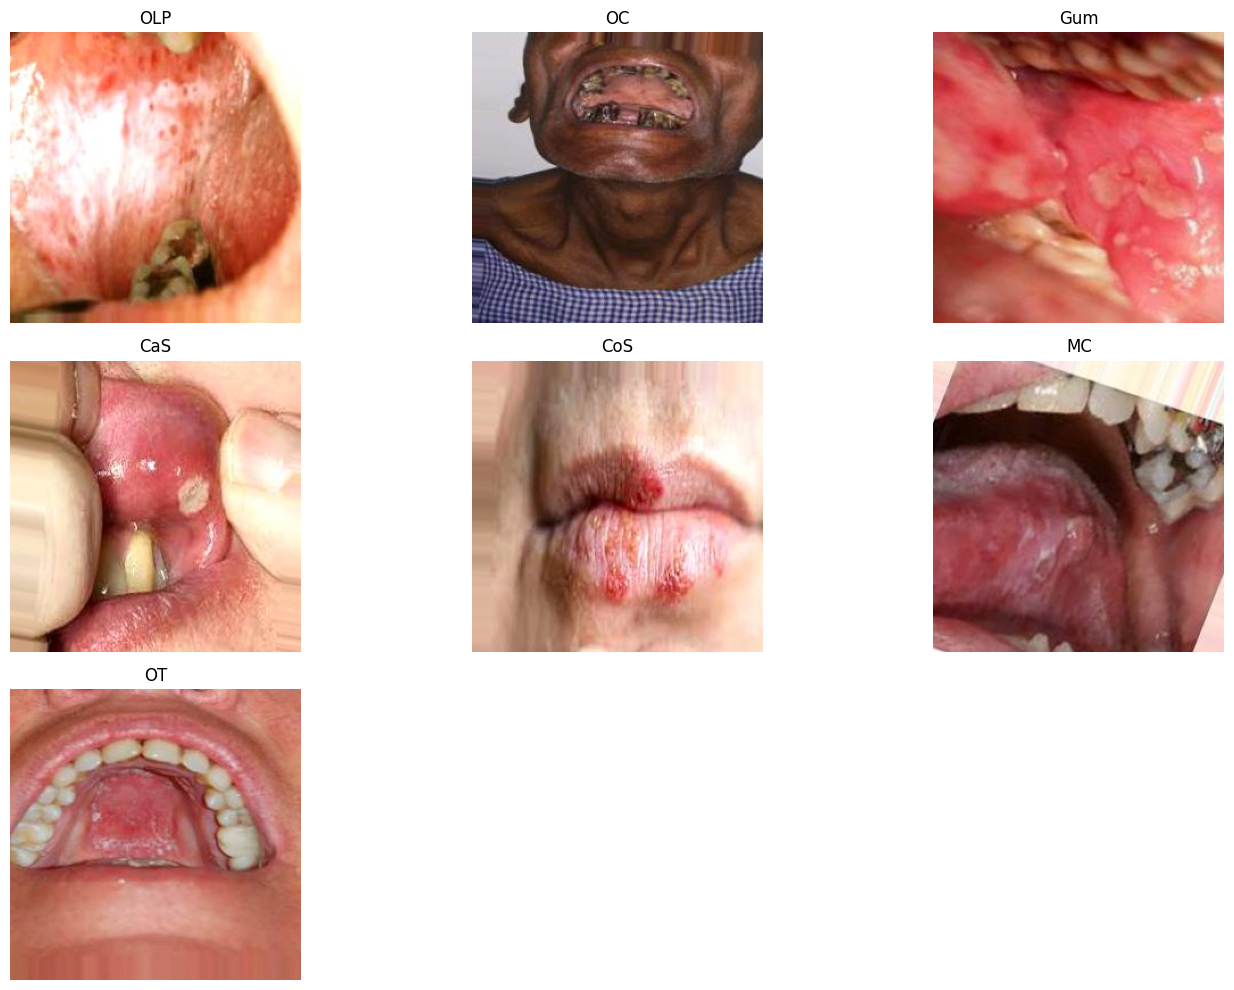

In [17]:
from PIL import Image
import os
import matplotlib.pyplot as plt
# List of classes (subfolders)
classes = os.listdir(train_dir)  # Use the actual directory path here

# Function to plot sample images from each class
def plot_sample_images(train_dir, classes):
    plt.figure(figsize=(14, 10))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(train_dir, class_name)
        sample_image = os.listdir(class_path)[0]  # Get first image
        image_path = os.path.join(class_path, sample_image)
        img = Image.open(image_path)

        # Plot the image
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images(train_dir, classes)  # Pass the directory path

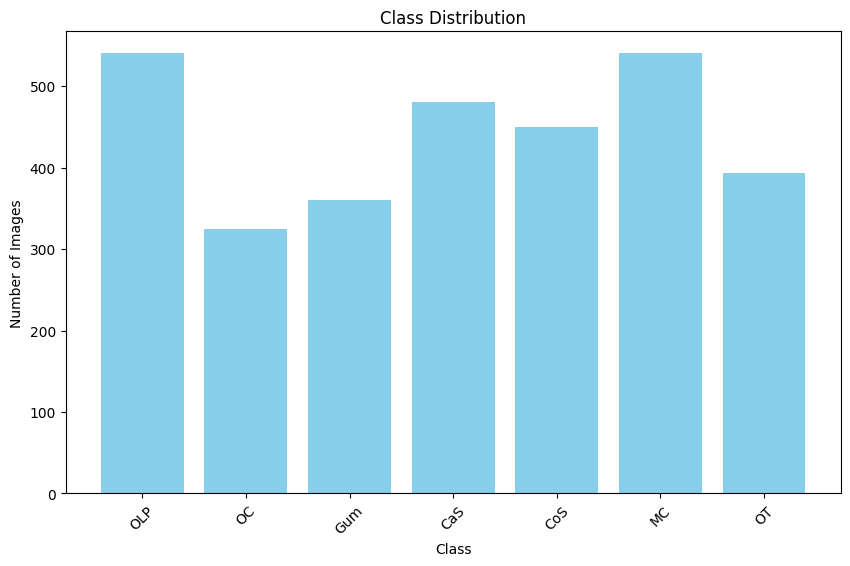

{'OLP': 540, 'OC': 324, 'Gum': 360, 'CaS': 480, 'CoS': 450, 'MC': 540, 'OT': 393}


In [18]:
# Function to count images in each class
def count_images_in_classes(train_dir, classes):
    class_distribution = {}
    for class_name in classes:
        class_path = os.path.join(train_dir, class_name)
        # Count the number of files (images) in the class folder
        num_images = len(os.listdir(class_path))
        class_distribution[class_name] = num_images
    return class_distribution

# Get the class distribution
class_distribution = count_images_in_classes(train_dir, classes)

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

# Print the class distribution
print(class_distribution)

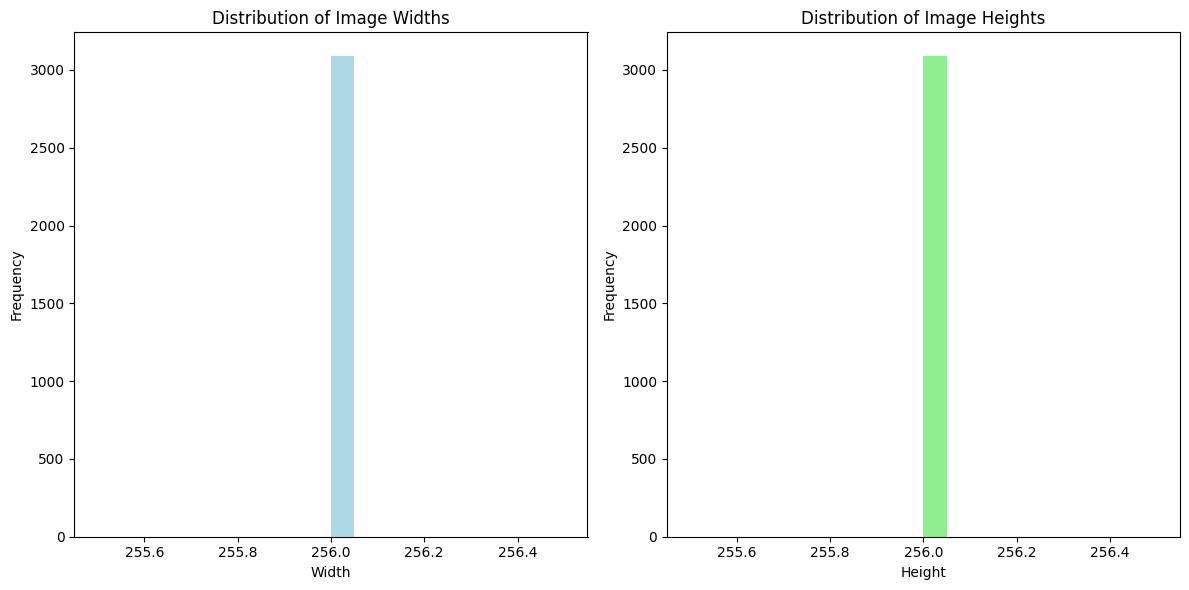

In [19]:
# Function to get image dimensions from all classes
def get_image_dimensions(train_dir, classes):
    dimensions = []
    for class_name in classes:
        class_path = os.path.join(train_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                dimensions.append(img.size)  # (width, height)
    return dimensions

# Get image dimensions
image_dimensions = get_image_dimensions(train_dir, classes)

# Separate widths and heights for analysis
widths = [dim[0] for dim in image_dimensions]
heights = [dim[1] for dim in image_dimensions]

# Plotting the distribution of image dimensions
plt.figure(figsize=(12, 6))

# Plot width distribution
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='lightblue')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths')

# Plot height distribution
plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='lightgreen')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights')

plt.tight_layout()
plt.show()


In [20]:

# Print basic statistics
print(f"Average Width: {sum(widths) / len(widths):.2f}")
print(f"Average Height: {sum(heights) / len(heights):.2f}")
print(f"Minimum Width: {min(widths)}, Maximum Width: {max(widths)}")
print(f"Minimum Height: {min(heights)}, Maximum Height: {max(heights)}")

Average Width: 256.00
Average Height: 256.00
Minimum Width: 256, Maximum Width: 256
Minimum Height: 256, Maximum Height: 256


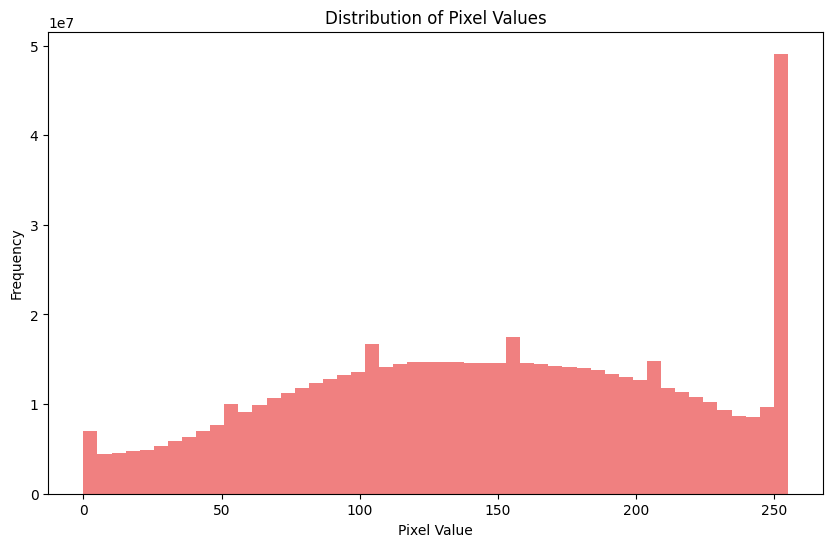

In [21]:
import numpy as np
# Function to calculate basic statistics for all images
def calculate_image_statistics(train_dir, classes):
    pixel_values = []

    for class_name in classes:
        class_path = os.path.join(train_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                img_array = np.array(img)  # Convert image to numpy array
                pixel_values.append(img_array)

    # Convert list of images to a single numpy array
    all_pixels = np.concatenate([img.flatten() for img in pixel_values])

    # Calculate basic statistics
    mean = np.mean(all_pixels)
    std_dev = np.std(all_pixels)
    min_pixel = np.min(all_pixels)
    max_pixel = np.max(all_pixels)

    return mean, std_dev, min_pixel, max_pixel, all_pixels

# Calculate statistics
mean, std_dev, min_pixel, max_pixel, all_pixels = calculate_image_statistics(train_dir, classes)

# Plotting pixel value distribution
plt.figure(figsize=(10, 6))
plt.hist(all_pixels, bins=50, color='lightcoral')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Values')
plt.show()



In [22]:
# Print basic statistics
print(f"Mean Pixel Value: {mean:.2f}")
print(f"Standard Deviation of Pixel Values: {std_dev:.2f}")
print(f"Minimum Pixel Value: {min_pixel}")
print(f"Maximum Pixel Value: {max_pixel}")

Mean Pixel Value: 145.74
Standard Deviation of Pixel Values: 68.18
Minimum Pixel Value: 0
Maximum Pixel Value: 255


In [23]:
# Load the dataset
batch_size = 32
img_size = (224, 224)  # ResNet expects 224x224 input size

In [24]:

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [25]:

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(512, activation='relu')(x)  # Fully connected layer
predictions = Dense(7, activation='softmax')(x)  # 7 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=7  # Adjust epochs based on your needs
)

Epoch 1/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 750s 8s/step - accuracy: 0.4844 - loss: 1.7327 - val_accuracy: 0.7879 - val_loss: 0.6217
Epoch 2/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 738s 8s/step - accuracy: 0.8658 - loss: 0.4203 - val_accuracy: 0.8658 - val_loss: 0.4000
Epoch 3/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 720s 7s/step - accuracy: 0.9448 - loss: 0.2020 - val_accuracy: 0.9125 - val_loss: 0.2767
Epoch 4/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 769s 8s/step - accuracy: 0.9785 - loss: 0.1016 - val_accuracy: 0.9261 - val_loss: 0.2100
Epoch 5/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 801s 8s/step - accuracy: 0.9904 - loss: 0.0550 - val_accuracy: 0.9329 - val_loss: 0.1897
Epoch 6/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 737s 8s/step - accuracy: 0.9986 - loss: 0.0224 - val_accuracy: 0.9523 - val_loss: 0.1558
Epoch 7/7
97/97 ━━━━━━━━━━━━━━━━━━━━ 741s 8s/step - accuracy: 0.9990 - loss: 0.0153 - val_accuracy: 0.9543 - val_loss: 0.1442


In [30]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.9721 - loss: 0.0885
Test Accuracy: 0.96
Test Loss: 0.1203


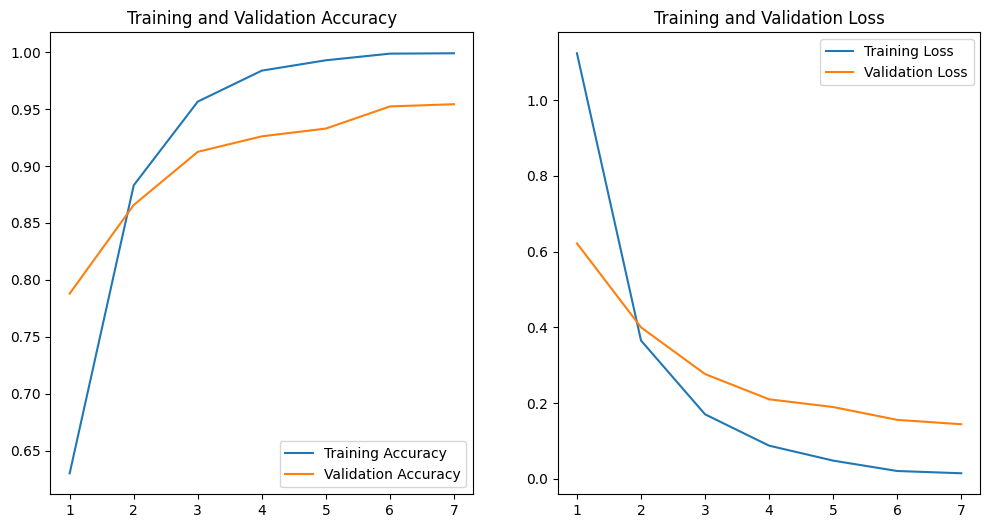

In [27]:
import matplotlib.pyplot as plt

# Extract data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step


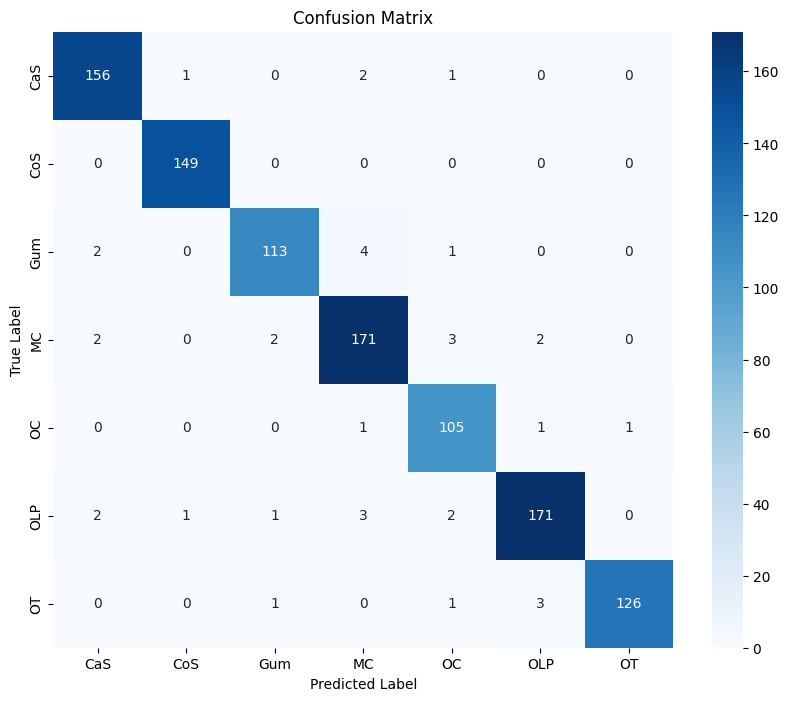

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=-1)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.class_names, yticklabels=test_dataset.class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [29]:
# Print the classification report
print(classification_report(y_true, y_pred, target_names=test_dataset.class_names))


              precision    recall  f1-score   support

         CaS       0.96      0.97      0.97       160
         CoS       0.99      1.00      0.99       149
         Gum       0.97      0.94      0.95       120
          MC       0.94      0.95      0.95       180
          OC       0.93      0.97      0.95       108
         OLP       0.97      0.95      0.96       180
          OT       0.99      0.96      0.98       131

    accuracy                           0.96      1028
   macro avg       0.96      0.96      0.96      1028
weighted avg       0.96      0.96      0.96      1028

